In [139]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from scipy.io import loadmat, savemat
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import scipy.io as sio
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint


dense_layers = [0, 1, 2, 3]
dense_sizes = [32, 64, 128, 256, 512]
conv_layers = [1, 2, 3, 4]
num_filters = [32, 64, 128, 256]
kernel_sizes = [2000, 2250, 2500, 2750, 3000]

rootPath = os.getcwd()
filePath = '/home/hymc/bf_test/code_matlab/DOA_deeplearning' + '/0107'
savePath = filePath + '/result'

if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)


dataPath = filePath + '/train/train_data.mat'
labelPath = filePath + '/train/train_label.mat'
x_train = sio.loadmat(dataPath)
y_train = sio.loadmat(labelPath)

dataPath = filePath + '/test/test_data.mat'
labelPath = filePath + '/test/test_label.mat'
x_test = sio.loadmat(dataPath)
y_test = sio.loadmat(labelPath)

# load data
x_train = x_train['train_data']  # noisy sample covariance matrix
y_train = y_train['train_label']  # original sample covariance matrix
print(x_train.shape)

x_test = x_test['test_data']
y_test = y_test['test_label']
print(x_train.shape)


/home/hymc/bf_test/code_matlab/DOA_deeplearning/0107/result
(5000, 400)
(5000, 400)


In [140]:
# train_data, test_data, train_labels, test_labels = train_test_split(
#     data, labels, test_size=0.2, random_state=21
# )

# Normalize the data to [0,1]
min_val = tf.reduce_min(x_train)
max_val = tf.reduce_max(x_train)
x_train = (x_train - min_val) / (max_val-min_val)

min_val = tf.reduce_min(y_train)
max_val = tf.reduce_max(y_train)
y_train = (y_train - min_val) / (max_val-min_val)

x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)

In [141]:
min_val = tf.reduce_min(x_test)
max_val = tf.reduce_max(x_test)
x_test = (x_test - min_val) / (max_val-min_val)

min_val = tf.reduce_min(y_test)
max_val = tf.reduce_max(y_test)
y_test = (y_test - min_val) / (max_val-min_val)

x_test  = tf.cast(x_test, tf.float32)
y_test  = tf.cast(y_test, tf.float32)

In [ ]:
# create scaler (Normalization)
# scaler = MinMaxScaler()
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# y_train = scaler.fit_transorm(y_tra)

In [142]:
# Model configuration
nSample = x_train.shape[0]
epoch = 1000
batch_size = 32
validation_split = 0.2

save_dir = os.path.join(os.getcwd(), 'save_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(save_dir)

/home/hymc/PycharmProjects/Autoencoder_example/save_models


In [143]:
class DOA_Denoising(Model):
    def __init__(self):
        super(DOA_Denoising, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(300, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(200, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(100, activation='relu')])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(200, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(300, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(400, activation='linear')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = DOA_Denoising() 

In [87]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 29704), started 0:01:31 ago. (Use '!kill 29704' to kill it.)

In [146]:
model_name = f'epoch-{epoch}-batch-{batch_size}-dense-300-200-100-time-{int(time.time())}'
print(model_name)

file_path = os.path.join(save_dir, model_name)
print(file_path)

# callbacks_list
callbacks_list = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30),
    ModelCheckpoint(filepath=file_path, monitor='val_loss', verbose=0, save_best_only=True,
                    save_weights_only=False,
                    mode='min'),
    TensorBoard(log_dir='./logs/{}'.format(model_name), histogram_freq=1, write_graph=False, write_images=False)
]

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x_train, y_train,
                          epochs=epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=validation_split)

autoencoder.encoder.summary()
autoencoder.decoder.summary()

epoch-1000-batch-32-dense-300-200-100-time-1641566355
/home/hymc/PycharmProjects/Autoencoder_example/save_models/epoch-1000-batch-32-dense-300-200-100-time-1641566355
Epoch 1/1000


2022-01-07 23:39:15.083816: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-01-07 23:39:15.086810: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


125/125 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0435
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0417
Epoch 3/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0417
Epoch 4/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0416
Epoch 5/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0416
Epoch 6/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0416
Epoch 7/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0416
Epoch 8/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0417
Epoch 9/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss: 0.0416
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss:

125/125 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0406
Epoch 81/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0412
Epoch 82/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0422
Epoch 83/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0427
Epoch 84/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0410
Epoch 85/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0417
Epoch 86/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0409
Epoch 87/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0407
Epoch 88/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0412
Epoch 89/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0380 - v

Epoch 159/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0408
Epoch 160/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0405
Epoch 161/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0402
Epoch 162/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0432
Epoch 163/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0449
Epoch 164/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0404
Epoch 165/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0402
Epoch 166/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0426
Epoch 167/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0417
Epoch 168/1000
125/125 [==============================] - 0s 2ms

Epoch 238/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0425
Epoch 239/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0442
Epoch 240/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0436
Epoch 241/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0440
Epoch 242/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0425
Epoch 243/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0428
Epoch 244/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0435
Epoch 245/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0431
Epoch 246/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0414
Epoch 247/1000
125/125 [==============================] - 0s 2ms

Epoch 317/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0428
Epoch 318/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0424
Epoch 319/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0415
Epoch 320/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0440
Epoch 321/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0428
Epoch 322/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0421
Epoch 323/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0405
Epoch 324/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0421
Epoch 325/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0434
Epoch 326/1000
125/125 [==============================] - 0s 1ms

Epoch 396/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0438
Epoch 397/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0431
Epoch 398/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0437
Epoch 399/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0421
Epoch 400/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0423
Epoch 401/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0426
Epoch 402/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0421
Epoch 403/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0432
Epoch 404/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0424
Epoch 405/1000
125/125 [==============================] - 0s 2ms

Epoch 475/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0454
Epoch 476/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0452
Epoch 477/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0485
Epoch 478/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0467
Epoch 479/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0465
Epoch 480/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0459
Epoch 481/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0472
Epoch 482/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0459
Epoch 483/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0460
Epoch 484/1000
125/125 [==============================] - 0s 2ms

Epoch 554/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0423
Epoch 555/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0438
Epoch 556/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0433
Epoch 557/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0427
Epoch 558/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0415
Epoch 559/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0434
Epoch 560/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0418
Epoch 561/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0419
Epoch 562/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0427
Epoch 563/1000
125/125 [==============================] - 0s 1ms

Epoch 633/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0453
Epoch 634/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0448
Epoch 635/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0430
Epoch 636/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0432
Epoch 637/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0447
Epoch 638/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0435
Epoch 639/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0442
Epoch 640/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0437
Epoch 641/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0435
Epoch 642/1000
125/125 [==============================] - 0s 1ms

Epoch 712/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0437
Epoch 713/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0430
Epoch 714/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0453
Epoch 715/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0417
Epoch 716/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0437
Epoch 717/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0425
Epoch 718/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0440
Epoch 719/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0446
Epoch 720/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0433
Epoch 721/1000
125/125 [==============================] - 0s 1ms

Epoch 791/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0440
Epoch 792/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0430
Epoch 793/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0435
Epoch 794/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0457
Epoch 795/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0438
Epoch 796/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0433
Epoch 797/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0449
Epoch 798/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0427
Epoch 799/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0422
Epoch 800/1000
125/125 [==============================] - 0s 1ms

Epoch 870/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0445
Epoch 871/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0416
Epoch 872/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0425
Epoch 873/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0426
Epoch 874/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0418
Epoch 875/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0432
Epoch 876/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0427
Epoch 877/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0436
Epoch 878/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0421
Epoch 879/1000
125/125 [==============================] - 0s 1ms

Epoch 949/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0441
Epoch 950/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0445
Epoch 951/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0443
Epoch 952/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0418
Epoch 953/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0431
Epoch 954/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0440
Epoch 955/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0423
Epoch 956/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0434
Epoch 957/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0434
Epoch 958/1000
125/125 [==============================] - 0s 1ms

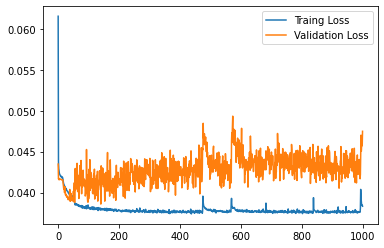

In [147]:
plt.plot(history.history["loss"], label="Traing Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('10.png')

tf.Tensor(
[[0.        0.        0.        ... 0.        4.53051   0.       ]
 [0.        0.        0.        ... 0.        4.5818977 0.       ]
 [0.        0.        0.        ... 0.        4.4090858 0.       ]
 ...
 [0.        0.        0.        ... 0.        4.737672  0.       ]
 [0.        0.        0.        ... 0.        4.958677  0.       ]
 [0.        0.        0.        ... 0.        4.667513  0.       ]], shape=(1000, 100), dtype=float32)
[[0.        0.        0.        ... 0.        4.53051   0.       ]
 [0.        0.        0.        ... 0.        4.5818977 0.       ]
 [0.        0.        0.        ... 0.        4.4090858 0.       ]
 ...
 [0.        0.        0.        ... 0.        4.737672  0.       ]
 [0.        0.        0.        ... 0.        4.958677  0.       ]
 [0.        0.        0.        ... 0.        4.667513  0.       ]]


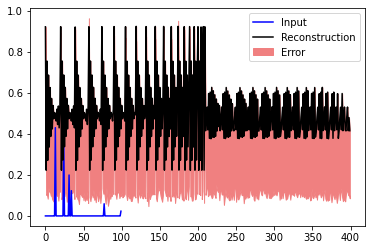

In [149]:
encoded_data = autoencoder.encoder(x_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(encoded_data[0],'b')
plt.plot(decoded_data[0],'k')
plt.fill_between(np.arange(400),decoded_data[0],x_test[0],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])

In [134]:
print(savePath)

savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})

/home/hymc/bf_test/code_matlab/DOA_deeplearning/0107/result
/home/hymc/bf_test/code_matlab/DOA_deeplearning/0107/result/denoised_data.mat


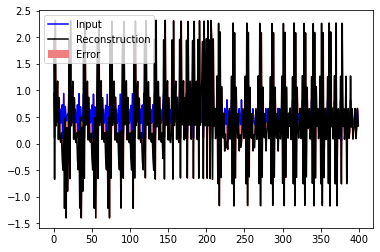

In [103]:
encoded_data = autoencoder.encoder(y_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(y_test[0],'b')
plt.plot(decoded_data[0],'k')
plt.fill_between(np.arange(400),decoded_data[0],y_test[0],color='lightcoral')
plt.legend(labels=["Input", "Reconstruction","Error"])

(1000, 400)
(1000,)


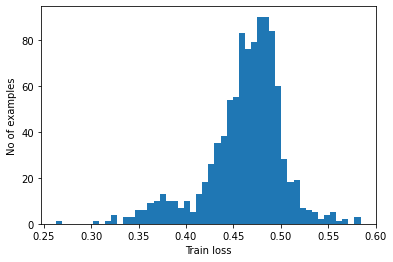

In [110]:
# Detect anomalies
reconstructions = autoencoder.predict(x_test)
print(reconstructions.shape)
train_loss = losses.mse(reconstructions, y_test)
print(train_loss.shape)
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [107]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:",threshold)

Threshold: 0.6027002


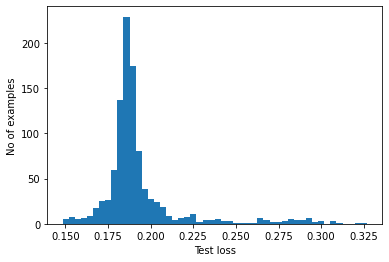

In [109]:
# reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mse(x_test, y_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, predictions)}")
  print(f"Precision = {precision_score(labels, predictions)}")
  print(f"Recall = {recall_score(labels, predictions)}")

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)